In [1]:
!pip install openml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.3 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.1-py3-none-any.whl size=146945 sha256=94dc81febcabb4217b7564dbd04c8e098c68e249bef5d088e2eb3c7cdbdc8e54
  Stored in directory: /root/.cache/pip/wheels/32/36/84/ecba92f5f56d34b17ba902bd51ae55d22b86a482467f7abe44
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11730 sha256=26efc39635df07a7fcdb8573e009033f4dab6d07495304517e0d8d9030b0ed26
  Stored in directory: /root/.cache/pip/wheels/08/82/8b/5c514221984e88c059b94e36a71d4722e590acaae04deab22e
Successfully built openml liac-arff

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install wordcloud==1.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.4/460.4 kB 28.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

from typing import Dict, Tuple, Union, List
from tqdm import tqdm
import openml
import re
import unicodedata
import sklearn
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold,train_test_split, GridSearchCV
from tabulate import tabulate
from bs4 import BeautifulSoup as bs
import collections
import string
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Preprocesamiento

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
validation = pd.read_csv('validation.csv')

# Une los DataFrames
df = pd.concat([train, validation, test], ignore_index=True)

# Guarda el DataFrame final en un nuevo archivo CSV
df.to_csv("dataset_twitter_esp.csv", index=False)

# Separacion de texto y etiquetas
X = df['text']
y = df['label']
print(len(X))
print(len(y))

3033
3033


Text(0.5, 1.0, 'Distribución de caracteres usados')

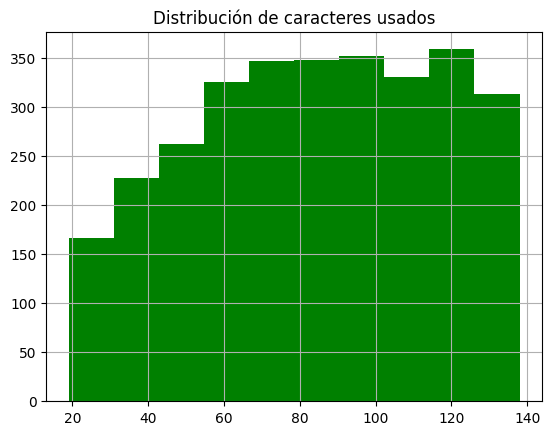

In [5]:
df['text'].str.len().hist(color='green')
plt.title("Distribución de caracteres usados")

In [7]:
print(df)

                                                   text  label
0     estoy hasta el ojete de que me digáis que teng...      0
1     @user Por?  Tenía pensado verla después de la ...      1
2                              Esto de estar feliz mola      2
3                                Ya no es tan divertido      0
4     @user te recuerdo que soy una persona que tien...      1
...                                                 ...    ...
3028  @user a mi a las 8.15 que son las 7.15, no too...      1
3029  @user Ah bueno, gracias por estar taaaan pendi...      2
3030  @user Esto es lo más triste :! Pero espero que...      0
3031  @user @user pregunta seria.  para cuando kedad...      1
3032  Nosotras somos muy interesantes, sí. Y no tene...      2

[3033 rows x 2 columns]


Text(0.5, 1.0, 'Negativos')

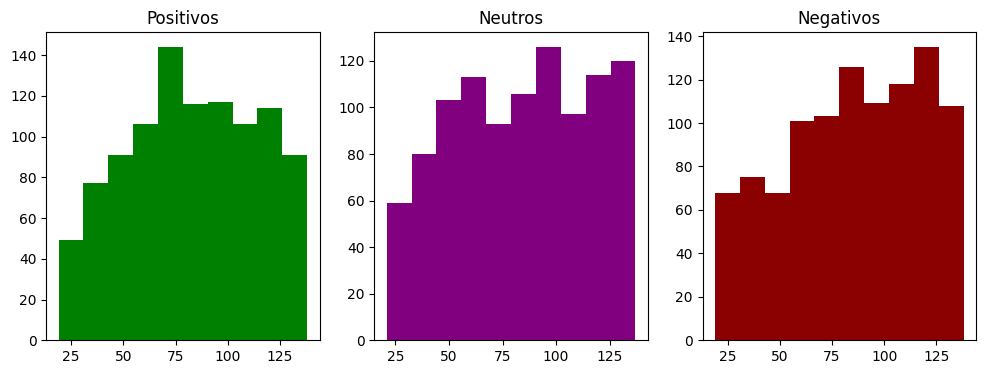

In [8]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(12,4))
ax1.hist(df[df['label']==2]['text'].str.len(), color='green')
ax1.set_title('Positivos')
ax2.hist(df[df['label']==1]['text'].str.len(), color='purple')
ax2.set_title('Neutros')
ax3.hist(df[df['label']==0]['text'].str.len(), color='darkred')
ax3.set_title('Negativos')

In [10]:
# Funciones de preprocesamiento
def sust_url(texto):
    texto = re.sub(r"(?P<url>https?://[^\s]+)", "_url", texto)
    texto = re.sub(r"(watch\S+)", "_url", texto)
    texto = re.sub(r"(www\S+)", "_url", texto)
    texto = re.sub(r"(\w+\.(com))", "_url", texto)
    texto = re.sub(r"(\w)\1+", r"\1", texto)
    return texto

def limpiar(texto):
    texto = texto.lower()
    texto = re.sub(r'@\w+', '', texto)
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\d+', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

def sw(texto):
    words = word_tokenize(texto)
    words1 = [word for word in words if word not in stopwords.words('spanish')]
    words1 = [p for p in words1 if len(p) > 1] 
    texto = ' '.join(words1)
    return texto

def stem_palabras(tokens):
    stemmer = SnowballStemmer("spanish")
    return [stemmer.stem(token) for token in tokens]

In [11]:
# Corpus tras la eliminación de:
# @usuarios de redes sociales, eliminación de espacios en blancos en las palabras,
# eliminación de caracteres especiales y eliminación de números
clean_X = [limpiar(content) for content in X]
print(clean_X[:10])

['estoy hasta el ojete de que me digáis que tengo cara de mala leche', 'por tenía pensado verla después de la segunda de daredevil', 'esto de estar feliz mola', 'ya no es tan divertido', 'te recuerdo que soy una persona que tiene criterio equivocado pero lo tengo', 'con una pequeña donación hará felices a miles de chicas que no tienen asociacionmariloli', 'he probado una nueva espuma para el pelo y sí que lo deja más rizado pero se queda como efecto gomina y no me gusta', 'ojalá pudiera darte el abrazo en vivo o al menos acompañarte hoy siento mucho lo de tu primo', 'aquí tienes a mi bae aka una egipcia preciosa que esta aprendiendo español os llevareis bien', 'ya somos dos que triste']


In [12]:
# Lista de palabras tras un segundo paso de limpieza:
# se tokenizan las palabras, se eliminan las palabras de parada en español,
# se eliminan las palabras de longitud texto y se reunen las palabras tokenizadas
clean_X = [sw(content) for content in clean_X]
print(clean_X[:10])

['ojete digáis cara mala leche', 'pensado verla después segunda daredevil', 'feliz mola', 'tan divertido', 'recuerdo persona criterio equivocado', 'pequeña donación hará felices miles chicas asociacionmariloli', 'probado nueva espuma pelo deja rizado queda efecto gomina gusta', 'ojalá pudiera darte abrazo vivo menos acompañarte hoy siento primo', 'aquí bae aka egipcia preciosa aprendiendo español llevareis bien', 'dos triste']


In [13]:
# Finalmente, se realiza un tercer proceso de limpieza:
# Sustitución de los URL por la expresión '_url' y eliminación las URL restantes
clean_X = [sust_url(content) for content in clean_X]
print(clean_X[:10])

['ojete digáis cara mala leche', 'pensado verla después segunda daredevil', 'feliz mola', 'tan divertido', 'recuerdo persona criterio equivocado', 'pequeña donación hará felices miles chicas asociacionmariloli', 'probado nueva espuma pelo deja rizado queda efecto gomina gusta', 'ojalá pudiera darte abrazo vivo menos acompañarte hoy siento primo', 'aquí bae aka egipcia preciosa aprendiendo español levareis bien', 'dos triste']


In [14]:
clean_X[:10]

['ojete digáis cara mala leche',
 'pensado verla después segunda daredevil',
 'feliz mola',
 'tan divertido',
 'recuerdo persona criterio equivocado',
 'pequeña donación hará felices miles chicas asociacionmariloli',
 'probado nueva espuma pelo deja rizado queda efecto gomina gusta',
 'ojalá pudiera darte abrazo vivo menos acompañarte hoy siento primo',
 'aquí bae aka egipcia preciosa aprendiendo español levareis bien',
 'dos triste']

## Modelo de bolsa de palabras

In [15]:
# Crear una copia del DataFrame
df_aux = df.copy(deep=True)

df_aux

,text,label
0,estoy hasta el ojete de que me digáis que teng...,0
1,@user Por? Tenía pensado verla después de la ...,1
2,Esto de estar feliz mola,2
3,Ya no es tan divertido,0
4,@user te recuerdo que soy una persona que tien...,1
...,...,...
3028,"@user a mi a las 8.15 que son las 7.15, no too...",1
3029,"@user Ah bueno, gracias por estar taaaan pendi...",2
3030,@user Esto es lo más triste :! Pero espero que...,0
3031,@user @user pregunta seria. para cuando kedad...,1


In [16]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(clean_X, y, test_size=0.3, stratify=y, random_state=0)

### Análisis con el diccionario 1

Extracción del diccionario 1

Este recurso contiene los sentimientos asociados a nivel lema para palabras en español. Para cada lemma, provee una estimación de polaridad (de muy negativo -1.0 a muy positivo +1.0) y una desviación estándar (relacionada a la ambigüedad de la estimación de polaridad).

El archivo utilizado es senticon.es.xml. A cada lemma se le asoció un nivel de positividad o neagtividad entre -1 y 1 a semejanza del SentiWordNet 3.0.

In [17]:
# dict1
# Asigna un peso a los palabras entre -1 y 1
# Su peso es negativo si la palabra tiene asociado una connotacion negativa
# Su peso es positivo si la palabra tiene asociada un significado palabra positva
dict1 = dict()
dict_std = dict()
with open(r'senticon.es.xml', 'r', encoding = 'utf-8') as rfile:
    content = rfile.readlines()
    content = "".join(content)
    bs_content = bs(content, "lxml")
    lemmas = bs_content.find_all("lemma")
    token = [i.get_text()[1:-1] for i in lemmas]
    pols = [float(i.get('pol')) for i in lemmas]
    stds = [float(i.get('std')) for i in lemmas]
    for i in range(len(token)):
        dict1[token[i]] = pols[i] 
        dict_std[token[i]] = stds[i]

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [20]:
for clave, valor in list(dict1.items())[:10]:
    print(f"{clave}: {valor}")

acertado: 0.708
admirable: 0.906
admiración: 0.45
admirar: 0.75
afectivo: 0.375
afecto: 0.321
afectuoso: 0.563
afición: 0.5
afortunado: 0.813
agradable: 0.75


In [21]:
for clave, valor in list(dict_std.items())[:10]:
    print(f"{clave}: {valor}")

acertado: 0.149
admirable: 0.125
admiración: 0.331
admirar: 0.177
afectivo: 0.0
afecto: 0.112
afectuoso: 0.131
afición: 0.425
afortunado: 0.063
agradable: 0.181


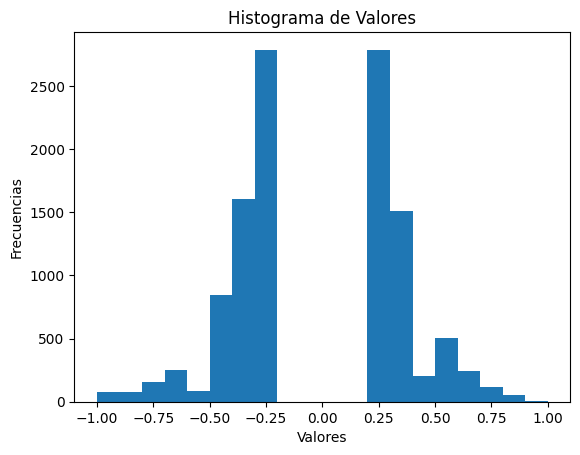

In [22]:
# Obtén los valores del diccionario
valores = list(dict1.values())

# Define el rango de valores en el eje x
rango_valores = np.arange(-1, 1.1, 0.1)

# Crea figura y eje
fig, ax = plt.subplots()

# Crea histograma de frecuencias
ax.hist(valores, bins=rango_valores)

# Personaliza el histograma
ax.set_xlabel("Valores")
ax.set_ylabel("Frecuencias")
ax.set_title("Histograma de Valores")

# Muestra el histograma
plt.show()

In [23]:
# Valores para consultar que efectivamente el mínimo valor positivo asociado a un palabra es 0.25 y -0.25
# Obtén los valores numéricos del diccionario
valores = list(dict1.values())

# Crea listas vacías para almacenar los valores positivos y negativos
valores_positivos = []
valores_negativos = []

# Clasifica los valores en las listas correspondientes (positivos o negativos)
for valor in valores:
    if valor > 0:
        valores_positivos.append(valor)
    elif valor < 0:
        valores_negativos.append(valor)

# Encuentra el mínimo positivo y el mínimo negativo
minimo_positivo = min(valores_positivos) if valores_positivos else None
minimo_negativo = max(valores_negativos) if valores_negativos else None

print("Mínimo positivo:", minimo_positivo)
print("Mínimo negativo:", minimo_negativo)

Mínimo positivo: 0.25
Mínimo negativo: -0.25


In [24]:
# Agrupar texto por clases
# Almacenar las palabras de cada clase en una lista y esta a su vez como una clave del diccionario
dict_class_reviews = dict()
ls_class_0 = list()
ls_class_1 = list()
ls_class_2 = list()
for i in range(len(clean_X)):
    if y.iloc[i] == 0:
        ls_class_0.append(clean_X[i])
    elif y.iloc[i] == 1:
        ls_class_1.append(clean_X[i])
    elif y.iloc[i] == 2:
        ls_class_2.append(clean_X[i])
        
dict_class_reviews[0] = ls_class_0
dict_class_reviews[1] = ls_class_1
dict_class_reviews[2] = ls_class_2

In [25]:
avg_pols_rev = list()
avg_results = dict()
results_unitary = dict()
# Se recorren los documentos dentro de cada una de las clases
for i in range(len(dict_class_reviews)):
    ls_class = dict_class_reviews[i]
    sum_pols_rev = list()
    for rev in ls_class:
        rev = rev.split()
        pols_rev = list()
        for w in rev:
            try:
                pols_rev.append(dict1[w])
            except:
                pass
        pols_rev = np.array(pols_rev)
        sum_pols_rev.append(sum(pols_rev))

    sum_pols_rev = np.array(sum_pols_rev)
    results_unitary[i] = sum_pols_rev
    avg_pols_rev.append(sum(sum_pols_rev) / len(ls_class))

In [26]:
# Crear una lista de resultados decimales
result_decimals_unitary = np.concatenate((results_unitary[0], results_unitary[1], results_unitary[2]))

In [27]:
# Clasificacion de las predicciones con base en el intervalo de confianza dado por la desviación estándar del diccionario
intervalo_confianza = 0.3
#intervalo_confianza = np.mean(list(dict_std.values()))
print("Intervalo de confianza: ", intervalo_confianza)
polarity_predics = list()

for i in range(len(result_decimals_unitary)):
    if (result_decimals_unitary[i]>=intervalo_confianza):
        polarity_predics.append(2)
    elif (result_decimals_unitary[i]<=(-1*intervalo_confianza)):
        polarity_predics.append(0)
    else:
        polarity_predics.append(1)

Intervalo de confianza:  0.3


In [28]:
data = {'Valor real': y, 'Valor decimal': result_decimals_unitary, 'Prediccion': polarity_predics}
results_dic1 = pd.DataFrame(data)
results_dic1

,Valor real,Valor decimal,Prediccion
0,0,0.000,1
1,1,0.653,2
2,2,0.542,2
3,0,-0.509,0
4,1,0.000,1
...,...,...,...
3028,1,0.750,2
3029,2,0.000,1
3030,0,1.292,2
3031,1,0.500,2


In [29]:
# Calcular las métricas de clasificación
y_true = results_dic1['Valor real'].tolist()
y_pred = results_dic1['Prediccion'].tolist()
reporte_clasificacion = classification_report(y_true, y_pred)
reporte_clasificacion

'              precision    recall  f1-score   support\n\n           0       0.36      0.10      0.15      1011\n           1       0.32      0.54      0.40      1011\n           2       0.32      0.33      0.32      1011\n\n    accuracy                           0.32      3033\n   macro avg       0.33      0.32      0.29      3033\nweighted avg       0.33      0.32      0.29      3033\n'

In [30]:
# Calcular las métricas de clasificación individualmente
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # Opciones: 'micro', 'macro', 'weighted', 'samples'
recall = recall_score(y_true, y_pred, average='macro')  # Opciones: 'micro', 'macro', 'weighted', 'samples'
f1 = f1_score(y_true, y_pred, average='macro')  # Opciones: 'micro', 'macro', 'weighted', 'samples'

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.32245301681503463
Precision: 0.33084887575594923
Recall: 0.3224530168150346
F1-score: 0.29264317492404684


In [31]:
avg_pols_rev

[0.05373392680514349, 0.15517804154302664, 0.3617586547972301]

In [32]:
results = []
for i in range(len(avg_pols_rev)):
    results.append([i, avg_pols_rev[i]])

#res_dict1 = [[i, avg_pols_rev[i]] for i in range(len(avg_pols_rev))]

In [33]:
print(tabulate(results, headers = ['Classes', 'Average Polarity'],
                   tablefmt = 'fancy_grid', numalign = 'center'))

╒═══════════╤════════════════════╕
│  Classes  │  Average Polarity  │
╞═══════════╪════════════════════╡
│     0     │     0.0537339      │
├───────────┼────────────────────┤
│     1     │      0.155178      │
├───────────┼────────────────────┤
│     2     │      0.361759      │
╘═══════════╧════════════════════╛


Conclusión: El Accuracy obtenido con este diccionario es bajo, debido a que muchas de las palabras no están en el diccionario provisto. Por ende, se debería buscar un diccionario que incluya más palabras actuales y de uso común. En este caso, no se pueden agregar palabras al diccionario, ya que no conocemos la forma de determinar el valor decimal de cada una de ellas.

## Análisis con el diccionario 2

Full Strength Lexicon

Veronica Perez-Rosas, Carmen Banea and Rada Mihalcea

Language and Information Technologies
University of North Texas

Los lexicons son provistos en formato de texto plano. El nombre del diccionario es fullStrengthLexicon.

El archivo fullStrengthLexicon contiene un léxico de sentimientos en Español que aprovecha las anotaciones manuales de opiniones del léxico OpinionFinder (Wiebe et al., 2005). Aunado a lo anterior, este archivo contiene un léxico que aprovecha las anotaciones automáticas inducida basada en SentiWordNet.

El formato de este léxico es como sigue:

Spanish_word  Synset_offset_in_WN_1_6  English_annotation  [Spanish_annotation]

donde:

- Spanish_word es una palabra en español sin marcas diacríticas (como acentos).

- Synset_offset_in_WN_1_6 es el desplazamiento synset correspondiente a  WordNet 1.6.

- English_annotation es el correspondiente sentimiento que fue automáticamente generado usando los métodos descritos en el texto del siguiente link: http://lit.csci.unt.edu/

- [Spanish annotation] es una anotación manual del sentimiento provista por dos personas hispanoparlantes.

Extraccion del diccionario 2

In [34]:
dict2 = dict()
with open(r'fullStrengthLexicon.txt', 'r', encoding = 'utf-8') as rfile:
    content = rfile.readlines()
    token = list()
    pols = list()

    # Se recorre cada línea del diccionario
    for line in content:
        if line != '\n': # si en la línea hay algo diferente a un salto de línea
            line_ls = line.split() # se separa la línea en palabras
            token.append(line_ls[0]) # Se guardan las palabras
            pols.append(line_ls[2]) # Se guarda el sentimiento asociado
    
    # Guarda en el diccionario con la clave que corresponde a la palabra y el valor asociado
    for i in range(len(token)):
        dict2[token[i]] = pols[i] 

In [35]:
for clave, valor in list(dict2.items())[:10]:
    print(f"{clave}: {valor}")

abundancia: neg
abundante: pos
adecuado: pos
admirable: pos
adorar: pos
agitacion: neg
agotamiento: neg
agradable: pos
agudo: neg
alerta: pos


Counter({'neg': 877, 'pos': 477})


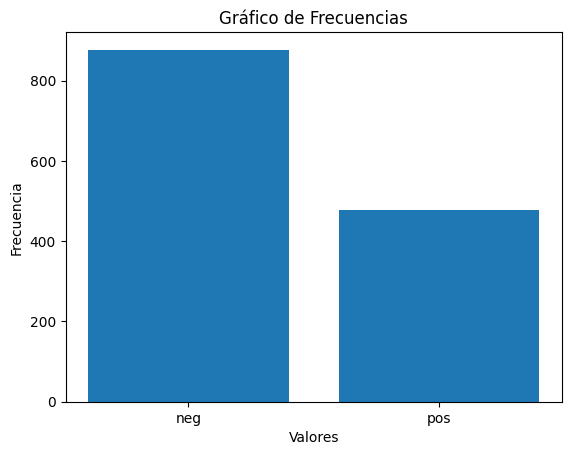

In [36]:
# Gráfico de frecuencias

# Contar las frecuencias de los valores
frecuencias = collections.Counter(dict2.values())
print(frecuencias)

# Obtener los valores y las frecuencias
valores = list(frecuencias.keys())
conteos = list(frecuencias.values())

# Crear el gráfico de barras
plt.bar(valores, conteos)

# Configurar etiquetas y título del gráfico
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Frecuencias')

# Mostrar el gráfico
plt.show()

In [37]:
# Incoporar al diccionario las palabras de cada clase que no están en el diccionario original a partir del corpus de tweets

# Lista para almacenar los tokens
tokens_lista_original = []
label_original_0 = [] #lista de palabras positivas
label_original_1 = [] # lista de palabras neutras
label_original_2 = [] #lista de palabras negativas

# Recorrer cada elemento de la lista clean_X, tokenizarlo y agregarlo a la lista de tokens
# Armamos una lista de palabras positivas, neutras y negativas a partir del corpus.
for i in range(len(clean_X)):
    tokens = word_tokenize(clean_X[i]) # Se tokeniza cada doc del corpus
    for token in tokens:
        # Si la etiqueta asociada al doc es igual a 0 (nagativa)
        if y.iloc[i] == 0: 
            if (token not in label_original_2): # se verifica que la palabra no este en la lita de las positivas 
                label_original_0.append(token) # si no está, se agrega a la lista de las palabras negativas
            elif(token in label_original_2):
                label_original_2.remove(token)
                label_original_1.append(token)
        elif y.iloc[i] == 2: # si la etiqueta es dos
            if (token not in label_original_0): # se verifica que la palabra no este en la lista positiva
                label_original_2.append(token) # se agrega a la lista de las palabras negativas
            elif(token in label_original_0): # si esta en la lista positiva
                label_original_0.remove(token) # se saca de la lista de palabra spositivas
                label_original_1.append(token) # se agrega a la lista de palabras neutras
        elif y.iloc[i] == 1: #no pasa esto, porque no hay documentos etiquetados como neutros
            if (token not in label_original_0) and (token not in label_original_2): 
                label_original_1.append(token)
            elif(token in label_original_0):
                label_original_0.remove(token)
                label_original_1.append(token)
            elif(token in label_original_2):
                label_original_2.remove(token)
                label_original_1.append(token)



Counter({'neg': 2562, 'pos': 2395, 'neutral': 1443})


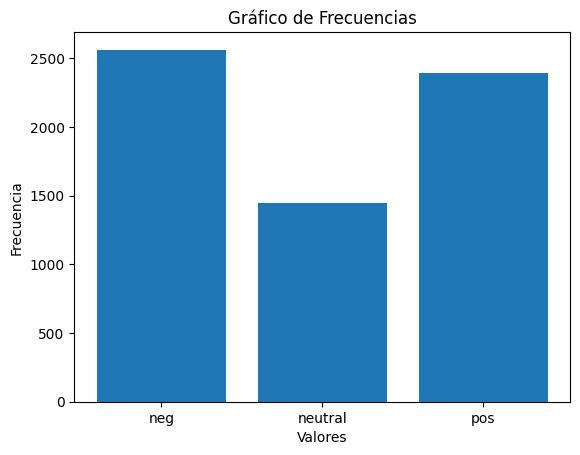

In [38]:
# Creación del diccionario propio a partir del corpus
valor0 = 'neg'
valor1 = 'neutral'
valor2 = 'pos'

diccionario_corpus = {}

for elemento0, elemento1, elemento2 in zip(label_original_0, label_original_1, label_original_2):
    diccionario_corpus[elemento0] = valor0
    diccionario_corpus[elemento1] = valor1
    diccionario_corpus[elemento2] = valor2

# Gráfico de frecuencias

# Contar las frecuencias de los valores
frecuencias = collections.Counter(diccionario_corpus.values())
print(frecuencias)

# Obtener los valores y las frecuencias
valores = list(frecuencias.keys())
conteos = list(frecuencias.values())

# Crear el gráfico de barras
plt.bar(valores, conteos)

# Configurar etiquetas y título del gráfico
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Frecuencias')

# Mostrar el gráfico
plt.show()

In [39]:
# Almacenar las palabras de cada clase en una lista y esta a su vez como una clave del diccionario
dict_class_reviews = dict()
ls_class_0 = list()
ls_class_1 = list()
ls_class_2 = list()
for i in range(len(clean_X)):
    if y.iloc[i] == 0:
        ls_class_0.append(clean_X[i])
    elif y.iloc[i] == 1:
        ls_class_1.append(clean_X[i])
    elif y.iloc[i] == 2:
        ls_class_2.append(clean_X[i])
        
dict_class_reviews[0] = ls_class_0
dict_class_reviews[1] = ls_class_1
dict_class_reviews[2] = ls_class_2

In [40]:
nivel_confianza = 0.15
percentages = []
balance_sentimiento = []

#num_clases = [0,2]
# Se recorren los documentos dentro de cada una de las clases
for i in range(len(dict_class_reviews)):
    ls_class = dict_class_reviews[i]
    sum_pols_rev = list()
    pols_rev = list()
    # Se recorre cada documentos almacenados en cada clave del diccionario
    for rev in ls_class:
        rev = rev.split() # Se separa cada palabra de cada documento en la clave del diccionario que se este recorriendo
        pos_counter = 0
        neg_counter = 0
        # Se busca cada palabra en el diccionario y se aumenta el conteo de palabras positivas o negativas según sea el valor asociado a tal palabra
        for w in rev:
            try:
                pol = dict2[w]
                if (pol == 'pos'):
                    pos_counter += 1
                elif (pol == 'neg'):
                    neg_counter += 1
            except:
                try:
                    pol = diccionario_corpus[w]
                    if (pol == 'pos'):
                        pos_counter += 1
                    elif (pol == 'neg'):
                        neg_counter += 1
                except:
                    pass
        
        balance_sentimiento.append(pos_counter)
        balance_sentimiento.append(neg_counter)
        #print(balance_sentimiento)
        maximo = max(balance_sentimiento)
        #print(maximo)
        margen_confianza = int(nivel_confianza * maximo)
        #print(margen_confianza)

        # En funcion del conteo de palabras se determina si el documento es pos, neutral o negativo
        if (pos_counter > (neg_counter+margen_confianza)):
            pols_rev.append('pos')
        elif (pos_counter == neg_counter):
            pols_rev.append('neutral')
        elif (neg_counter > (pos_counter+margen_confianza)):
            pols_rev.append('neg')
        elif ((abs(pos_counter-neg_counter))<=margen_confianza):
            pols_rev.append('neutral')
        balance_sentimiento = []

    # Conteo de documentos clasificados en cada clase
    pos_counter_class = 0
    neutral_counter_class = 0
    neg_counter_class = 0
    for pol in pols_rev:
        if pol == 'pos':
            pos_counter_class += 1
        elif pol == 'neutral':
            neutral_counter_class += 1
        else:
            neg_counter_class += 1
    
    #print(len(pols_rev))
    ## Porcentaje de documentos clasificados en cada clase
    #porcentaje_positivos = str(round(100 * pos_counter_class / len(pols_rev), 2)) + '%'
    #print(porcentaje_positivos)
    #porcentaje_neutral = str(round(100 * neutral_counter_class / len(pols_rev), 2)) + '%'
    #print(porcentaje_neutral)
    #porcentaje_neg =  str(round(100 * neg_counter_class / len(pols_rev), 2)) + '%'
    #print(porcentaje_neg)
    percentages.append([str(round(100 * pos_counter_class / len(pols_rev), 2)) + '%',
                        str(round(100 * neutral_counter_class / len(pols_rev), 2)) + '%',
                        str(round(100 * neg_counter_class / len(pols_rev), 2)) + '%'])

In [41]:
percentages

[['5.84%', '8.61%', '85.56%'],
 ['48.57%', '26.9%', '24.53%'],
 ['93.67%', '4.35%', '1.98%']]

In [42]:
res_dict2 = [[i, percentages[i][0], percentages[i][1], percentages[i][2]] for i in range(len(percentages))]

In [43]:
print(tabulate(res_dict2, headers = ['Classes', '% Positive Polarity', '% Neutral Polarity', '% Negative Polarity'],
                   tablefmt = 'fancy_grid', numalign = 'center'))

╒═══════════╤═══════════════════════╤══════════════════════╤═══════════════════════╕
│  Classes  │ % Positive Polarity   │ % Neutral Polarity   │ % Negative Polarity   │
╞═══════════╪═══════════════════════╪══════════════════════╪═══════════════════════╡
│     0     │ 5.84%                 │ 8.61%                │ 85.56%                │
├───────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│     1     │ 48.57%                │ 26.9%                │ 24.53%                │
├───────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│     2     │ 93.67%                │ 4.35%                │ 1.98%                 │
╘═══════════╧═══════════════════════╧══════════════════════╧═══════════════════════╛


Conjunto de entrenamiento y de prueba

In [44]:
X_train, X_test, y_train, y_test = train_test_split(clean_X, y, test_size=0.3, stratify=y, random_state=0)

In [45]:
# Incoporar al diccionario las palabras de cada clase que no están en el diccionario original a partir del corpus de tweets

# Lista para almacenar los tokens
tokens_lista_original = []
label_original_0 = [] #lista de palabras positivas
label_original_1 = []
label_original_2 = [] #lista de palabras negativas

# Recorrer cada elemento de la lista clean_X, tokenizarlo y agregarlo a la lista de tokens
# Armamos una lista de palabras positivas, neutras y negativas a partir del corpus.
for i in range(len(X_train)):
    tokens = word_tokenize(X_train[i]) # Se tokeniza cada doc del corpus
    for token in tokens:
        # Si la etiqueta asociada al doc es igual a 0 (nagativa)
        if y_train.iloc[i] == 0: 
            if (token not in label_original_2): # se verifica que la palabra no este en la lita de las positivas 
                label_original_0.append(token) # si no está, se agrega a la lista de las palabras negativas
            elif(token in label_original_2):
                label_original_2.remove(token)
                label_original_1.append(token)
        elif y_train.iloc[i] == 2: # si la etiqueta es dos
            if (token not in label_original_0): # se verifica que la palabra no este en la lista positiva
                label_original_2.append(token) # se agrega a la lista de las palabras negativas
            elif(token in label_original_0): # si esta en la lista positiva
                label_original_0.remove(token) # se saca de la lista de palabra spositivas
                label_original_1.append(token) # se agrega a la lista de palabras neutras
        elif y_train.iloc[i] == 1: #no pasa esto, porque no hay documentos etiquetados como neutros
            if (token not in label_original_0) and (token not in label_original_2): 
                label_original_1.append(token)
            elif(token in label_original_0):
                label_original_0.remove(token)
                label_original_1.append(token)
            elif(token in label_original_2):
                label_original_2.remove(token)
                label_original_1.append(token)

Counter({'neg': 2022, 'pos': 1881, 'neutral': 1243})


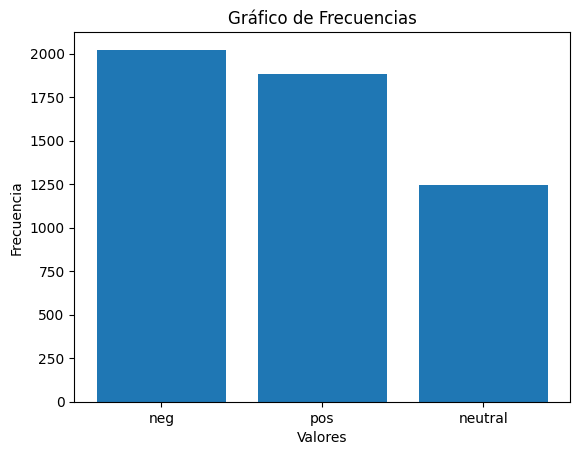

In [46]:
# Creación del diccionario propio a partir del corpus
valor0 = 'neg'
valor1 = 'neutral'
valor2 = 'pos'

diccionario_corpus = {}

for elemento0, elemento1, elemento2 in zip(label_original_0, label_original_1, label_original_2):
    diccionario_corpus[elemento0] = valor0
    diccionario_corpus[elemento1] = valor1
    diccionario_corpus[elemento2] = valor2

# Gráfico de frecuencias

# Contar las frecuencias de los valores
frecuencias = collections.Counter(diccionario_corpus.values())
print(frecuencias)

# Obtener los valores y las frecuencias
valores = list(frecuencias.keys())
conteos = list(frecuencias.values())

# Crear el gráfico de barras
plt.bar(valores, conteos)

# Configurar etiquetas y título del gráfico
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Frecuencias')

# Mostrar el gráfico
plt.show()

In [47]:
# Almacenar las palabras de cada clase en una lista y esta a su vez como una clave del diccionario
dict_class_reviews = dict()
ls_class_0 = list()
ls_class_1 = list()
ls_class_2 = list()
for i in range(len(X_test)):
    if y_test.iloc[i] == 0:
        ls_class_0.append(X_test[i])
    elif y_test.iloc[i] == 1:
        ls_class_1.append(X_test[i])
    elif y_test.iloc[i] == 2:
        ls_class_2.append(X_test[i])
        
dict_class_reviews[0] = ls_class_0
dict_class_reviews[1] = ls_class_1
dict_class_reviews[2] = ls_class_2

In [49]:
nivel_confianza = 0.15
percentages = []
balance_sentimiento = []

# Se recorren los documentos dentro de cada una de las clases
for i in range(len(dict_class_reviews)):
    ls_class = dict_class_reviews[i]
    sum_pols_rev = list()
    pols_rev = list()
    # Se recorre cada documentos almacenados en cada clave del diccionario
    for rev in ls_class:
        rev = rev.split() # Se separa cada palabra de cada documento en la clave del diccionario que se este recorriendo
        pos_counter = 0
        neg_counter = 0
        # Se busca cada palabra en el diccionario y se aumenta el conteo de palabras positivas o negativas según sea el valor asociado a tal palabra
        for w in rev:
            try:
                pol = dict2[w]
                if (pol == 'pos'):
                    pos_counter += 1
                elif (pol == 'neg'):
                    neg_counter += 1
            except:
                try:
                    pol = diccionario_corpus[w]
                    if (pol == 'pos'):
                        pos_counter += 1
                    elif (pol == 'neg'):
                        neg_counter += 1
                except:
                    pass
        
        balance_sentimiento.append(pos_counter)
        balance_sentimiento.append(neg_counter)
        #print(balance_sentimiento)
        maximo = max(balance_sentimiento)
        #print(maximo)
        margen_confianza = int(nivel_confianza * maximo)
        #print(margen_confianza)

        # En funcion del conteo de palabras se determina si el documento es pos, neutral o negativo
        if (pos_counter > (neg_counter+margen_confianza)):
            pols_rev.append('pos')
        elif (pos_counter == neg_counter):
            pols_rev.append('neutral')
        elif (neg_counter > (pos_counter+margen_confianza)):
            pols_rev.append('neg')
        elif ((abs(pos_counter-neg_counter))<=margen_confianza):
            pols_rev.append('neutral')
        balance_sentimiento = []

    # Conteo de documentos clasificados en cada clase
    pos_counter_class = 0
    neutral_counter_class = 0
    neg_counter_class = 0
    for pol in pols_rev:
        if pol == 'pos':
            pos_counter_class += 1
        elif pol == 'neutral':
            neutral_counter_class += 1
        else:
            neg_counter_class += 1
    
    #print(len(pols_rev))
    ## Porcentaje de documentos clasificados en cada clase
    #porcentaje_positivos = str(round(100 * pos_counter_class / len(pols_rev), 2)) + '%'
    #print(porcentaje_positivos)
    #porcentaje_neutral = str(round(100 * neutral_counter_class / len(pols_rev), 2)) + '%'
    #print(porcentaje_neutral)
    #porcentaje_neg =  str(round(100 * neg_counter_class / len(pols_rev), 2)) + '%'
    #print(porcentaje_neg)
    percentages.append([str(round(100 * pos_counter_class / len(pols_rev), 2)) + '%',
                        str(round(100 * neutral_counter_class / len(pols_rev), 2)) + '%',
                        str(round(100 * neg_counter_class / len(pols_rev), 2)) + '%'])

In [51]:
percentages

[['27.96%', '27.3%', '44.74%'],
 ['47.85%', '22.77%', '29.37%'],
 ['64.69%', '21.45%', '13.86%']]

In [53]:
res_dict2 = [[i, percentages[i][0], percentages[i][1], percentages[i][2]] for i in range(len(percentages))]

In [54]:
print(tabulate(res_dict2, headers = ['Classes', '% Positive Polarity', '% Neutral Polarity', '% Negative Polarity'],
                   tablefmt = 'fancy_grid', numalign = 'center'))

╒═══════════╤═══════════════════════╤══════════════════════╤═══════════════════════╕
│  Classes  │ % Positive Polarity   │ % Neutral Polarity   │ % Negative Polarity   │
╞═══════════╪═══════════════════════╪══════════════════════╪═══════════════════════╡
│     0     │ 27.96%                │ 27.3%                │ 44.74%                │
├───────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│     1     │ 47.85%                │ 22.77%               │ 29.37%                │
├───────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│     2     │ 64.69%                │ 21.45%               │ 13.86%                │
╘═══════════╧═══════════════════════╧══════════════════════╧═══════════════════════╛


## Modelo de Naive Bayes

In [55]:
data = pd.read_csv('dataset_twitter_esp.csv')  

data = data.drop(data[data['label'] == 1].index) #Omitimos los neutros



X = data['text']
y = data['label']


#Limpiar

def limpiar(text):
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8') #acentos
    text = re.sub(r"\b\d+\b", "", text)  #elimina numeros
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'user', '', text) #quitar user  

    return text

X = [limpiar(content) for content in X]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy =accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)

Precisión: 0.7506172839506173


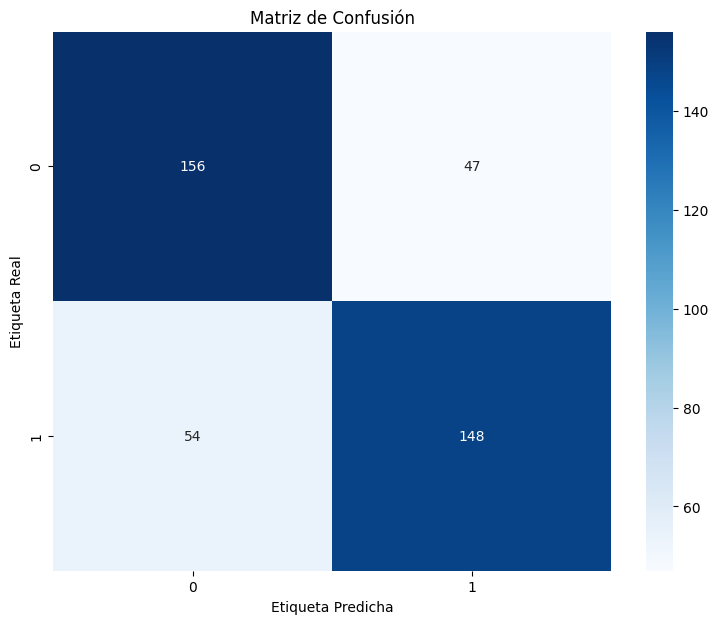

In [56]:
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, cmap="Blues",fmt='g')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [57]:
nuevos_tuits = ['Este es un tuit genial', 'Estoy muy triste hoy', 'No puedo creer lo que acabo de ver']
X_new = vectorizer.transform(nuevos_tuits)
y_new_pred = classifier.predict(X_new)
for tuit, sentimiento in zip(nuevos_tuits, y_new_pred):
    print(tuit, "=>", sentimiento)

Este es un tuit genial => 2
Estoy muy triste hoy => 0
No puedo creer lo que acabo de ver => 0


## Stop words

In [58]:
stop_words = stopwords.words('spanish')


data2 = data['text'].apply(limpiar)
data2 = pd.DataFrame(data2)
data2['label'] = data['label']
#Quitar stop words del español
stop_words = stopwords.words('spanish')

data2['text'] = data2['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [59]:
print(data[:10])
print(data2[:10])

                                                 text  label
0   estoy hasta el ojete de que me digáis que teng...      0
2                            Esto de estar feliz mola      2
3                              Ya no es tan divertido      0
5   @user @user @user con una pequeña donación har...      2
6   He probado una nueva espuma para el pelo y sí ...      0
8   @user aquí tienes a mi bae aka una egipcia pre...      2
9                      @user ya somos dos, que triste      0
11  #2AñosDeLegiónHolk Llevo como unos 8 meses Tal...      2
12  🌼 severus snape 🌼  -pobresito  -nunca le odié,...      0
14  Se echa de menos  #digital #art #life @ Escuel...      2
                                                 text  label
0                        ojete digais cara mala leche      0
2                                     Esto feliz mola      2
3                                    Ya tan divertido      0
5   pequena donacion hara felices miles chicas aso...      2
6   He probado nueva esp

In [60]:
X = data2['text']
y = data2['label']
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)

Precisión: 0.7160493827160493


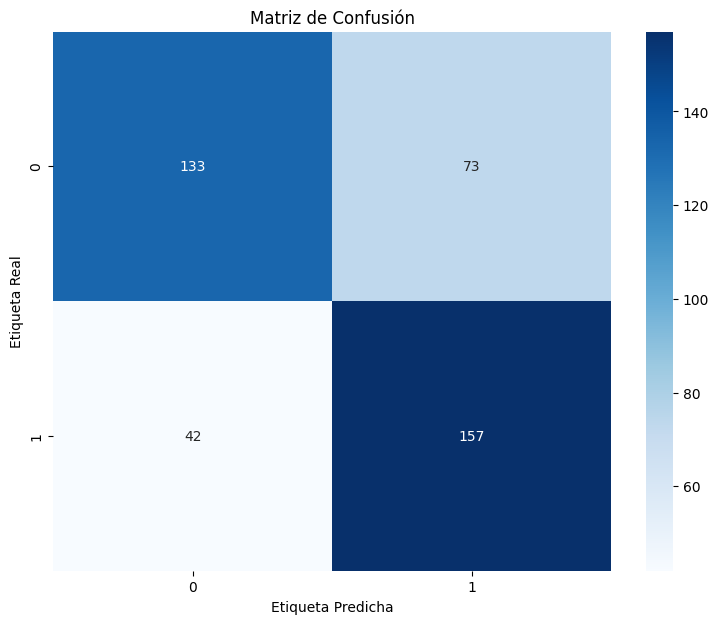

In [61]:
cm = confusion_matrix(y_test, y_pred)


# Visualizar la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, cmap="Blues",fmt='g')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

## Wordcloud

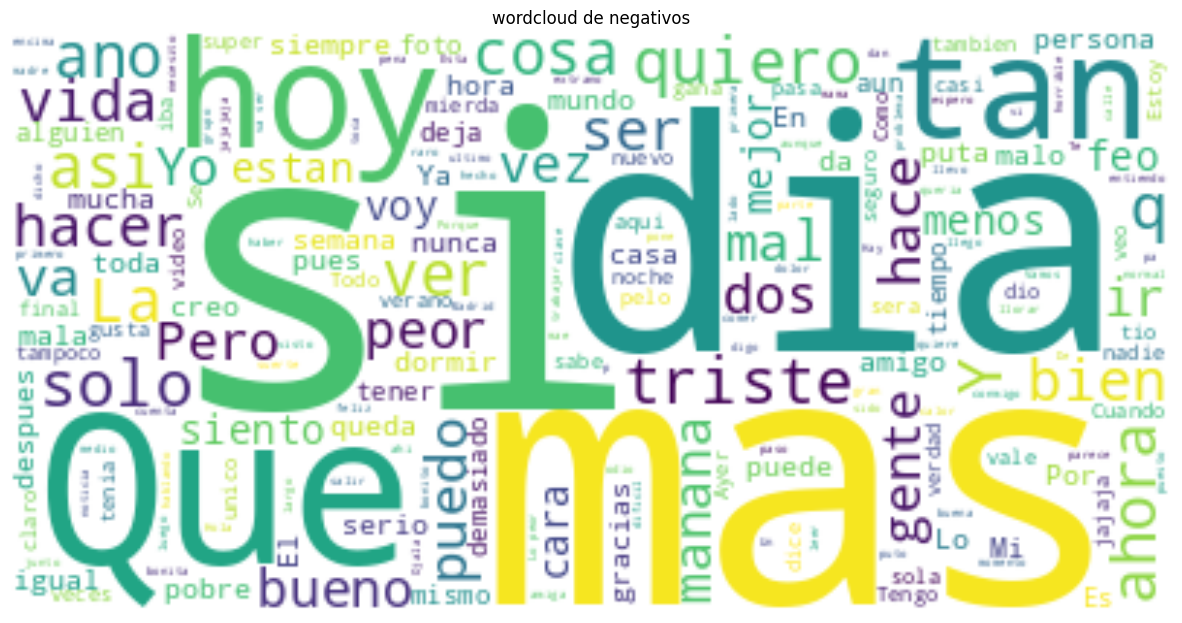

In [62]:
text = " ".join(i for i in data2[data2['label']==0]['text'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud de negativos')
plt.show()

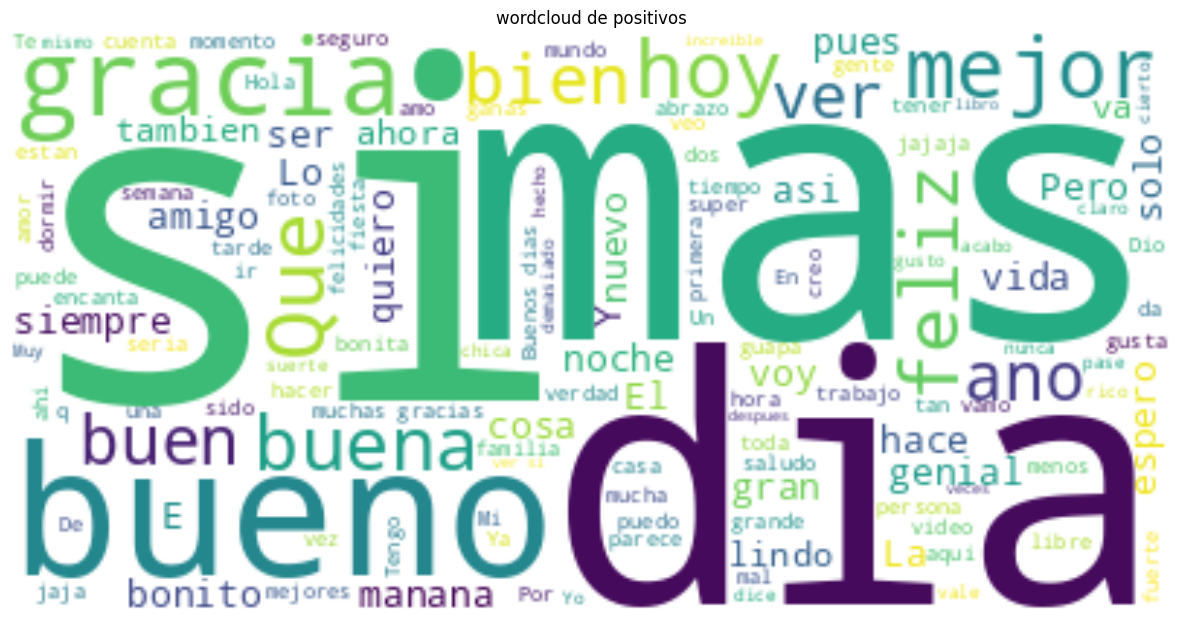

In [63]:
text = " ".join(i for i in data2[data2['label']==2]['text'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud de positivos')
plt.show()

# Stemming

In [64]:
def stem_palabras(tokens):
    stemmer = SnowballStemmer("spanish")
    
    return [stemmer.stem(token) for token in tokens]

data3 = stem_palabras(data2['text'])

In [65]:
compara = pd.DataFrame()
compara['d2'] = data2['text'][:10]
compara['d3'] = pd.Series(data3[:10])

compara

,d2,d3
0,ojete digais cara mala leche,ojete digais cara mala lech
2,Esto feliz mola,ya tan divert
3,Ya tan divertido,pequena donacion hara felices miles chicas aso...
5,pequena donacion hara felices miles chicas aso...,aqui bae aka egipcia preciosa aprendiendo espa...
6,He probado nueva espuma pelo si deja mas rizad...,dos tr
8,aqui bae aka egipcia preciosa aprendiendo espa...,severus snape pobresito nunca odie parecia est...
9,dos triste,se echa menos digital art life escuela superio...
11,2AnosDeLegionHolk Llevo meses Talvez menos mas...,NaN
12,severus snape pobresito nunca odie parecia est...,NaN
14,Se echa menos digital art life Escuela Superio...,NaN


In [66]:
X = data3
y = data2['label']
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)

Precisión: 0.7061728395061728


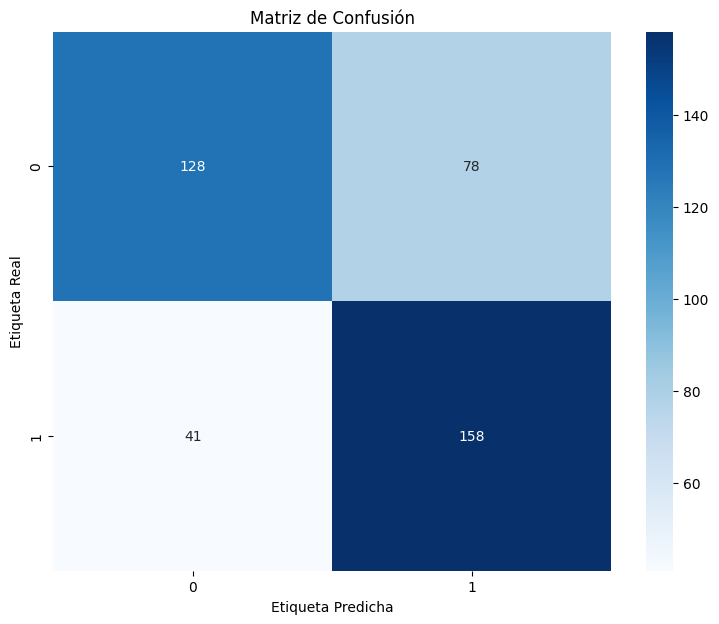

In [67]:
cm = confusion_matrix(y_test, y_pred)


# Visualizar la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, cmap="Blues",fmt = 'g')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [68]:
comp = pd.DataFrame()
comp['original'] = data['text']
comp['limpio'] = data['text'].apply(limpiar)
comp['no_sw'] = data2['text']
comp['stem'] = data3

comp.sample(10)

,original,limpio,no_sw,stem
138,Que ganas tengo de volver a disfruta pronto de...,Que ganas tengo de volver a disfruta pronto de...,Que ganas volver disfruta pronto lejano veo Si...,que ganas volver disfruta pronto lejano veo si...
2585,@user @user @user @user Ole los buenos almerie...,Ole los buenos almerienses Mil besitos,Ole buenos almerienses Mil besitos,ole buenos almerienses mil besit
383,"@user mejor así, que solo un grupo selecto lo ...",mejor asi que solo un grupo selecto lo sepa,mejor asi solo grupo selecto sepa,mejor asi solo grupo selecto sep
1629,"@user yo puedo cambiar de opinión, de cara es ...",yo puedo cambiar de opinion de cara es mas di...,puedo cambiar opinion cara mas dificil vale pasta,puedo cambiar opinion cara mas dificil vale past
2694,7 bulbasaur he conseguido y ninguno con buenas...,bulbasaur he conseguido y ninguno con buenas ...,bulbasaur conseguido ninguno buenas estadisticas,bulbasaur conseguido ninguno buenas estadist
2099,@user Muchas gracias Lorena !Que pases una tar...,Muchas gracias Lorena Que pases una tarde fan...,Muchas gracias Lorena Que pases tarde fantasti...,muchas gracias lorena que pases tarde fantasti...
1538,"@user gracias, compa. Es algo que no he olvida...",gracias compa Es algo que no he olvidado jama...,gracias compa Es olvidado jamas Es calidad hum...,gracias compa es olvidado jamas es calidad hum...
563,@user Y son más de las 5 de la mañana! Y encim...,Y son mas de las de la manana Y encima manan...,Y mas manana Y encima manana vuelve ser dia gr...,y mas manana y encima manana vuelve ser dia gr...
2004,@user 2 horas esperando en Comisaría Gandia y ...,horas esperando en Comisaria Gandia y han at...,horas esperando Comisaria Gandia atendido pers...,horas esperando comisaria gandia atendido pers...
6,He probado una nueva espuma para el pelo y sí ...,He probado una nueva espuma para el pelo y si ...,He probado nueva espuma pelo si deja mas rizad...,he probado nueva espuma pelo si deja mas rizad...


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6adfb73f-f262-454f-9a7b-b2149bd8079a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>